# Neural Network Model

The aim of the notebook is demo end to end pipeline for Ads prediction in Tensorflow

In [1]:
# ! ./setup.sh # uncomment if you wish to install any new packages

In [2]:
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import sys
from pathlib import Path
import datetime
import time
import numpy as np
import pandas as pd
from pprint import pprint
from typing import Dict, Any, Union, List, Tuple
from functools import partial
import re
import string
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from math import ceil
from collections import namedtuple
from sklearn.model_selection import train_test_split
import pickle

import chakin
import json
import os
from collections import defaultdict
import zipfile
import sqlite3
import logging
from tempfile import TemporaryDirectory
from fastprogress import progress_bar
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import concatenate

import seaborn as sns

from EmbeddingFactory import EmbeddingFactory

pd.set_option('display.max_rows', None)

print(f"Using Tensorflow, {tf.__version__} on Python interpreter, {sys.version_info}")

Using Tensorflow, 2.1.0 on Python interpreter, sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)


In [3]:
RANDOM_SEED = int(time.time())

tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"Using random seed, {RANDOM_SEED}")

Using random seed, 1588998715


## Load Data

Dataset credits:
```
@inproceedings{roffo2016personality,
  title={Personality in computational advertising: A benchmark},
  author={Roffo, Giorgio and Vinciarelli, Alessandro},
  booktitle={4 th Workshop on Emotions and Personality in Personalized Systems (EMPIRE) 2016},
  pages={18},
  year={2016}
}
```

In [4]:
DATA_FOLDER = Path("../../dataset/")
BATCH_SIZE = 4096 # bigger the batch, faster the training but bigger the RAM needed
TARGET_COL = "Rating"

# data files path are relative DATA_FOLDER
users_ads_rating_csv = DATA_FOLDER/"users-ads-without-gcp-ratings_OHE_MLB_FAV_UNFAV_Merged.csv"

#### Declare columns names

In [5]:
USER_ID = "UserId"
AD_ID = "AdId"
AGE = "Age"
ZIP_CODE = "CapZipCode"
COUNTRIES_VISITED = "Countriesvisited"
FAVE_SPORTS = "FaveSports"
GENDER = "Gender"
HOME_COUNTRY = "Homecountry"
HOME_TOWN = "Hometown"
INCOME = "Income"
LAST_NAME = "LastName"
MOST_LISTENED_MUSICS = "Mostlistenedmusics"
MOST_READ_BOOKS = "Mostreadbooks"
MOST_VISITED_WEBSITES = "Mostvisitedwebsites"
MOST_WATCHED_MOVIES = "Mostwatchedmovies"
MOST_WATCHED_TV_PROGRAMMES = "Mostwatchedtvprogrammes"
NAME = "Name"
PAYPAL = "Paypal"
TIMEPASS = "Timepass"
TYPE_OF_JOB = "TypeofJob"
WEEKLY_WORKING_HOURS = "Weeklyworkinghours"
ADFILEPATH = "AdFilePath"
GENDER_F = "Gender_F"
GENDER_M = "Gender_M"
# HomeCountry = 12 Columns
HOMECOUNTRY_CANADA = "Homecountry_Canada"
HOMECOUNTRY_CZECHREPUBLIC = "Homecountry_CzechRepublic"
HOMECOUNTRY_GREATBRITAIN = "Homecountry_GreatBritain"
HOMECOUNTRY_INDIA = "Homecountry_India"
HOMECOUNTRY_ITALY = "Homecountry_Italy"
HOMECOUNTRY_PHILLIPINES = "Homecountry_Phillipines"
HOMECOUNTRY_ROMANIA = "Homecountry_Romania"
HOMECOUNTRY_SAUDIARABIA = "Homecountry_SaudiArabia"
HOMECOUNTRY_SINGAPORE = "Homecountry_Singapore"
HOMECOUNTRY_SLOVENIA = "Homecountry_Slovenia"
HOMECOUNTRY_UNITEDKINGDOM = "Homecountry_UnitedKingdom"
HOMECOUNTRY_UNITEDSTATESOFAMERICA = "Homecountry_UnitedStatesofAmerica"
# Income = 4 Columns
INCOME_0 = "Income_0"
INCOME_1 = "Income_1"
INCOME_2 = "Income_2"
INCOME_3 = "Income_3"
# Mostlistenedmusics = 22 Columns
MOSTLISTENEDMUSICS_1 = "AlternativeMusic"
MOSTLISTENEDMUSICS_2 = "AsianPopJPoporKpop"
MOSTLISTENEDMUSICS_3 = "Blues"
MOSTLISTENEDMUSICS_4 = "ClassicalMusic"
MOSTLISTENEDMUSICS_5 = "CountryMusic"
MOSTLISTENEDMUSICS_6 = "DanceMusic"
MOSTLISTENEDMUSICS_7 = "EasyListening"
MOSTLISTENEDMUSICS_8 = "ElectronicMusic"
MOSTLISTENEDMUSICS_9 = "EuropeanMusicFolkPop"
MOSTLISTENEDMUSICS_10 = "HipHopRap"
MOSTLISTENEDMUSICS_11 = "IndiePop"
MOSTLISTENEDMUSICS_12 = "InspirationalinclGospel"
MOSTLISTENEDMUSICS_13 = "Jazz"
MOSTLISTENEDMUSICS_14 = "LatinMusic"
MOSTLISTENEDMUSICS_15 = "NewAge"
MOSTLISTENEDMUSICS_16 = "Opera"
MOSTLISTENEDMUSICS_17 = "PopPopularmusic"
MOSTLISTENEDMUSICS_18 = "RampBSoul"
MOSTLISTENEDMUSICS_19 = "Reggae"
MOSTLISTENEDMUSICS_20 = "Rock"
MOSTLISTENEDMUSICS_21 = "SingerSongwriterincFolk"
MOSTLISTENEDMUSICS_22 = "WorldMusicBeats"
# Mostreadbooks = 31 Columns
MOSTREADBOOKS_1 = "ActionandAdventure"
MOSTREADBOOKS_2 = "Anthologies"
MOSTREADBOOKS_3 = "Art"
MOSTREADBOOKS_4 = "Autobiographies"
MOSTREADBOOKS_5 = "Biographies"
MOSTREADBOOKS_6 = "Childrens"
MOSTREADBOOKS_7 = "Childrensliterature"
MOSTREADBOOKS_8 = "Comics"
MOSTREADBOOKS_9 = "Cookbooks"
MOSTREADBOOKS_10 = "Diaries"
MOSTREADBOOKS_11 = "Drama"
MOSTREADBOOKS_12 = "Encyclopedias"
MOSTREADBOOKS_13 = "Eroticfiction"
MOSTREADBOOKS_14 = "Fantasy"
MOSTREADBOOKS_15 = "Guide"
MOSTREADBOOKS_16 = "History"
MOSTREADBOOKS_17 = "Horror"
MOSTREADBOOKS_18 = "Journals"
MOSTREADBOOKS_19 = "Math"
MOSTREADBOOKS_20 = "Mystery"
MOSTREADBOOKS_21 = "Poetry"
MOSTREADBOOKS_22 = "Prayerbooks"
MOSTREADBOOKS_23 = "Religious"
MOSTREADBOOKS_24 = "Romance"
MOSTREADBOOKS_25 = "Satire"
MOSTREADBOOKS_26 = "Science"
MOSTREADBOOKS_27 = "Sciencefiction"
MOSTREADBOOKS_28 = "Selfhelp"
MOSTREADBOOKS_29 = "Series"
MOSTREADBOOKS_30 = "Travel"
MOSTREADBOOKS_31 = "Trilogies"
# Mostwatchedmovies = 21 Columns
MOSTWATCHEDMOVIES_1 = "Mostwatchedmovies_Action"
MOSTWATCHEDMOVIES_2 = "Mostwatchedmovies_Adventure"
MOSTWATCHEDMOVIES_3 = "Mostwatchedmovies_Animation"
MOSTWATCHEDMOVIES_4 = "Mostwatchedmovies_Biography"
MOSTWATCHEDMOVIES_5 = "Mostwatchedmovies_Comedy"
MOSTWATCHEDMOVIES_6 = "Mostwatchedmovies_CrimeandGangster"
MOSTWATCHEDMOVIES_7 = "Mostwatchedmovies_Documentary"
MOSTWATCHEDMOVIES_8 = "Mostwatchedmovies_Drama"
MOSTWATCHEDMOVIES_9 = "Mostwatchedmovies_EpicHistorical"
MOSTWATCHEDMOVIES_10 = "Mostwatchedmovies_Erotic"
MOSTWATCHEDMOVIES_11 = "Mostwatchedmovies_Family"
MOSTWATCHEDMOVIES_12 = "Mostwatchedmovies_Fantasy"
MOSTWATCHEDMOVIES_13 = "Mostwatchedmovies_Horror"
MOSTWATCHEDMOVIES_14 = "Mostwatchedmovies_Musical"
MOSTWATCHEDMOVIES_15 = "Mostwatchedmovies_Mystery"
MOSTWATCHEDMOVIES_16 = "Mostwatchedmovies_Romance"
MOSTWATCHEDMOVIES_17 = "Mostwatchedmovies_SciFi"
MOSTWATCHEDMOVIES_18 = "Mostwatchedmovies_Sport"
MOSTWATCHEDMOVIES_19 = "Mostwatchedmovies_Thriller"
MOSTWATCHEDMOVIES_20 = "Mostwatchedmovies_War"
MOSTWATCHEDMOVIES_21 = "Mostwatchedmovies_Western"
# Mostwatchedtvprogrammes = 11 Columns
MOSTWATCHEDTVPROGRAMMES_1 = "Mostwatchedtvprogrammes_Childrens"
MOSTWATCHEDTVPROGRAMMES_2 = "Mostwatchedtvprogrammes_Comedy"
MOSTWATCHEDTVPROGRAMMES_3 = "Mostwatchedtvprogrammes_Drama"
MOSTWATCHEDTVPROGRAMMES_4 = "Mostwatchedtvprogrammes_EntertainmentVarietyShows"
MOSTWATCHEDTVPROGRAMMES_5 = "Mostwatchedtvprogrammes_Factual"
MOSTWATCHEDTVPROGRAMMES_6 = "Mostwatchedtvprogrammes_Learning"
MOSTWATCHEDTVPROGRAMMES_7 = "Mostwatchedtvprogrammes_Music"
MOSTWATCHEDTVPROGRAMMES_8 = "Mostwatchedtvprogrammes_News"
MOSTWATCHEDTVPROGRAMMES_9 = "Mostwatchedtvprogrammes_ReligionampEthics"
MOSTWATCHEDTVPROGRAMMES_10 = "Mostwatchedtvprogrammes_Sport"
MOSTWATCHEDTVPROGRAMMES_11 = "Mostwatchedtvprogrammes_Weather"

RATING = "Rating"
AD_NUM_FACES = "ad_num_faces"
AD_LABEL_FEATURE_1 = 'ad_isAdvertising'
AD_LABEL_FEATURE_2 = 'ad_isBrand'
AD_LABEL_FEATURE_3 = 'ad_isElectronicdevice'
AD_LABEL_FEATURE_4 = 'ad_isElectronics'
AD_LABEL_FEATURE_5 = 'ad_isFashionaccessory'
AD_LABEL_FEATURE_6 = 'ad_isFictionalcharacter'
AD_LABEL_FEATURE_7 = 'ad_isFont'
AD_LABEL_FEATURE_8 = 'ad_isFurniture'
AD_LABEL_FEATURE_9 = 'ad_isGadget'
AD_LABEL_FEATURE_10 = 'ad_isGames'
AD_LABEL_FEATURE_11 = 'ad_isGraphicdesign'
AD_LABEL_FEATURE_12 = 'ad_isGraphics'
AD_LABEL_FEATURE_13 = 'ad_isJewellery'
AD_LABEL_FEATURE_14 = 'ad_isLine'
AD_LABEL_FEATURE_15 = 'ad_isLogo'
AD_LABEL_FEATURE_16 = 'ad_isMagenta'
AD_LABEL_FEATURE_17 = 'ad_isMaterialproperty'
AD_LABEL_FEATURE_18 = 'ad_isMultimedia'
AD_LABEL_FEATURE_19 = 'ad_isProduct'
AD_LABEL_FEATURE_20 = 'ad_isRectangle'
AD_LABEL_FEATURE_21 = 'ad_isSkin'
AD_LABEL_FEATURE_22 = 'ad_isTechnology'
AD_LABEL_FEATURE_23 = 'ad_isText'
AD_LABEL_FEATURE_24 = 'ad_isVehicle'
AD_LABEL_FEATURE_25 = 'ad_isYellow'
AD_SAFESEARCH_FEATURE_1 = 'ad_isAdult_UNLIKELY'
AD_SAFESEARCH_FEATURE_2 ='ad_isAdult_VERY_UNLIKELY'
AD_SAFESEARCH_FEATURE_3 ='ad_isSpoof_POSSIBLE'
AD_SAFESEARCH_FEATURE_4 ='ad_isSpoof_UNLIKELY'
AD_SAFESEARCH_FEATURE_5 ='ad_isSpoof_VERY_UNLIKELY'
AD_SAFESEARCH_FEATURE_6 ='ad_isMedical_POSSIBLE'
AD_SAFESEARCH_FEATURE_7 ='ad_isMedical_UNLIKELY'
AD_SAFESEARCH_FEATURE_8 ='ad_isMedical_VERY_UNLIKELY'
AD_SAFESEARCH_FEATURE_9 ='ad_isViolence_VERY_UNLIKELY'
AD_SAFESEARCH_FEATURE_10 ='ad_isRacy_POSSIBLE'
AD_SAFESEARCH_FEATURE_11 ='ad_isRacy_UNLIKELY'
AD_SAFESEARCH_FEATURE_12 ='ad_isRacy_VERY_LIKELY'
AD_SAFESEARCH_FEATURE_13 ='ad_isRacy_VERY_UNLIKELY'
AD_OBJECT_FEATURE_1 = 'ad_isAnimal'
AD_OBJECT_FEATURE_2 ='ad_isBelt'
AD_OBJECT_FEATURE_3 ='ad_isBottle'
AD_OBJECT_FEATURE_4 ='ad_isBox'
AD_OBJECT_FEATURE_5 ='ad_isCameralens'
AD_OBJECT_FEATURE_6 ='ad_isChair'
AD_OBJECT_FEATURE_7 ='ad_isClothing'
AD_OBJECT_FEATURE_8 ='ad_isEarrings'
AD_OBJECT_FEATURE_9 ='ad_isFood'
AD_OBJECT_FEATURE_10 ='ad_isHat'
AD_OBJECT_FEATURE_11 ='ad_isLuggagebags'
AD_OBJECT_FEATURE_12 ='ad_isMobilephone'
AD_OBJECT_FEATURE_13 ='ad_isNecklace'
AD_OBJECT_FEATURE_14 ='ad_isPackagedgoods'
AD_OBJECT_FEATURE_15 ='ad_isPants'
AD_OBJECT_FEATURE_16 ='ad_isPen'
AD_OBJECT_FEATURE_17 ='ad_isPerson'
AD_OBJECT_FEATURE_18 ='ad_isPillow'
AD_OBJECT_FEATURE_19 ='ad_isPoster'
AD_OBJECT_FEATURE_20 ='ad_isShoe'
AD_OBJECT_FEATURE_21 ='ad_isTop'
AD_OBJECT_FEATURE_22 ='ad_isToy'
AD_OBJECT_FEATURE_23 ='ad_isWatch'
AD_OBJECT_FEATURE_24  ='ad_isWheel'
FAV = 'fav'
UNFAV = 'unfav'


# Read all columns as strings to avoid any errors
COL_DEFAULTS = {
    USER_ID: "**",
    AD_ID: "**",
    AGE: "**",
    ZIP_CODE: "**",
    COUNTRIES_VISITED: "**",
    FAVE_SPORTS: "**",
    GENDER: "**",
    HOME_COUNTRY: "**",
    HOME_TOWN: "**",
    INCOME: "**",
    LAST_NAME: "**",
    MOST_LISTENED_MUSICS: "**",
    MOST_READ_BOOKS: "**",
    MOST_VISITED_WEBSITES: "**",
    MOST_WATCHED_MOVIES: "**",
    MOST_WATCHED_TV_PROGRAMMES: "**",
    NAME: "**",
    PAYPAL: "**",
    TIMEPASS: "**",
    TYPE_OF_JOB: "**",
    WEEKLY_WORKING_HOURS: "**",
    ADFILEPATH: "**",
    GENDER_F: "**",
    GENDER_M: "**",
    HOMECOUNTRY_CANADA: "**",
    HOMECOUNTRY_CZECHREPUBLIC: "**",
    HOMECOUNTRY_GREATBRITAIN: "**",
    HOMECOUNTRY_INDIA: "**",
    HOMECOUNTRY_ITALY: "**",
    HOMECOUNTRY_PHILLIPINES: "**",
    HOMECOUNTRY_ROMANIA: "**",
    HOMECOUNTRY_SAUDIARABIA: "**",
    HOMECOUNTRY_SINGAPORE: "**",
    HOMECOUNTRY_SLOVENIA: "**",
    HOMECOUNTRY_UNITEDKINGDOM: "**",
    HOMECOUNTRY_UNITEDSTATESOFAMERICA: "**",
    INCOME_0: "**",
    INCOME_1: "**",
    INCOME_2: "**",
    INCOME_3: "**",
    MOSTLISTENEDMUSICS_1: "**",
    MOSTLISTENEDMUSICS_2: "**",
    MOSTLISTENEDMUSICS_3: "**",
    MOSTLISTENEDMUSICS_4: "**",
    MOSTLISTENEDMUSICS_5: "**",
    MOSTLISTENEDMUSICS_6: "**",
    MOSTLISTENEDMUSICS_7: "**",
    MOSTLISTENEDMUSICS_8: "**",
    MOSTLISTENEDMUSICS_9: "**",
    MOSTLISTENEDMUSICS_10: "**",
    MOSTLISTENEDMUSICS_11: "**",
    MOSTLISTENEDMUSICS_12: "**",
    MOSTLISTENEDMUSICS_13: "**",
    MOSTLISTENEDMUSICS_14: "**",
    MOSTLISTENEDMUSICS_15: "**",
    MOSTLISTENEDMUSICS_16: "**",
    MOSTLISTENEDMUSICS_17: "**",
    MOSTLISTENEDMUSICS_18: "**",
    MOSTLISTENEDMUSICS_19: "**",
    MOSTLISTENEDMUSICS_20: "**",
    MOSTLISTENEDMUSICS_21: "**",
    MOSTLISTENEDMUSICS_22: "**",
    MOSTREADBOOKS_1: "**",
    MOSTREADBOOKS_2: "**",
    MOSTREADBOOKS_3: "**",
    MOSTREADBOOKS_4: "**",
    MOSTREADBOOKS_5: "**",
    MOSTREADBOOKS_6: "**",
    MOSTREADBOOKS_7: "**",
    MOSTREADBOOKS_8: "**",
    MOSTREADBOOKS_9: "**",
    MOSTREADBOOKS_10: "**",
    MOSTREADBOOKS_11: "**",
    MOSTREADBOOKS_12: "**",
    MOSTREADBOOKS_13: "**",
    MOSTREADBOOKS_14: "**",
    MOSTREADBOOKS_15: "**",
    MOSTREADBOOKS_16: "**",
    MOSTREADBOOKS_17: "**",
    MOSTREADBOOKS_18: "**",
    MOSTREADBOOKS_19: "**",
    MOSTREADBOOKS_20: "**",
    MOSTREADBOOKS_21: "**",
    MOSTREADBOOKS_22: "**",
    MOSTREADBOOKS_23: "**",
    MOSTREADBOOKS_24: "**",
    MOSTREADBOOKS_25: "**",
    MOSTREADBOOKS_26: "**",
    MOSTREADBOOKS_27: "**",
    MOSTREADBOOKS_28: "**",
    MOSTREADBOOKS_29: "**",
    MOSTREADBOOKS_30: "**",
    MOSTREADBOOKS_31: "**",
    MOSTWATCHEDMOVIES_1: "**",
    MOSTWATCHEDMOVIES_2: "**",
    MOSTWATCHEDMOVIES_3: "**",
    MOSTWATCHEDMOVIES_4: "**",
    MOSTWATCHEDMOVIES_5: "**",
    MOSTWATCHEDMOVIES_6: "**",
    MOSTWATCHEDMOVIES_7: "**",
    MOSTWATCHEDMOVIES_8: "**",
    MOSTWATCHEDMOVIES_9: "**",
    MOSTWATCHEDMOVIES_10: "**",
    MOSTWATCHEDMOVIES_11: "**",
    MOSTWATCHEDMOVIES_12: "**",
    MOSTWATCHEDMOVIES_13: "**",
    MOSTWATCHEDMOVIES_14: "**",
    MOSTWATCHEDMOVIES_15: "**",
    MOSTWATCHEDMOVIES_16: "**",
    MOSTWATCHEDMOVIES_17: "**",
    MOSTWATCHEDMOVIES_18: "**",
    MOSTWATCHEDMOVIES_19: "**",
    MOSTWATCHEDMOVIES_20: "**",
    MOSTWATCHEDMOVIES_21: "**",
    MOSTWATCHEDTVPROGRAMMES_1: "**",
    MOSTWATCHEDTVPROGRAMMES_2: "**",
    MOSTWATCHEDTVPROGRAMMES_3: "**",
    MOSTWATCHEDTVPROGRAMMES_4: "**",
    MOSTWATCHEDTVPROGRAMMES_5: "**",
    MOSTWATCHEDTVPROGRAMMES_6: "**",
    MOSTWATCHEDTVPROGRAMMES_7: "**",
    MOSTWATCHEDTVPROGRAMMES_8: "**",
    MOSTWATCHEDTVPROGRAMMES_9: "**",
    MOSTWATCHEDTVPROGRAMMES_10: "**",
    MOSTWATCHEDTVPROGRAMMES_11: "**",    
    RATING: "**",
    AD_NUM_FACES: "**",
    FAV: "**",
    UNFAV: "**"
}


AD_FACE_COLS = [AD_NUM_FACES]
AD_LABEL_COLS = [AD_LABEL_FEATURE_1,AD_LABEL_FEATURE_2,AD_LABEL_FEATURE_3,AD_LABEL_FEATURE_4,AD_LABEL_FEATURE_5,
                AD_LABEL_FEATURE_6,AD_LABEL_FEATURE_7,AD_LABEL_FEATURE_8,AD_LABEL_FEATURE_9,AD_LABEL_FEATURE_10,
                AD_LABEL_FEATURE_11,AD_LABEL_FEATURE_12,AD_LABEL_FEATURE_13,AD_LABEL_FEATURE_14,AD_LABEL_FEATURE_15,
                AD_LABEL_FEATURE_16,AD_LABEL_FEATURE_17,AD_LABEL_FEATURE_18,AD_LABEL_FEATURE_19,AD_LABEL_FEATURE_20,
                AD_LABEL_FEATURE_21,AD_LABEL_FEATURE_22,AD_LABEL_FEATURE_23,AD_LABEL_FEATURE_24,AD_LABEL_FEATURE_25]

AD_OBJECT_COLS = [AD_OBJECT_FEATURE_1,AD_OBJECT_FEATURE_2,AD_OBJECT_FEATURE_3,AD_OBJECT_FEATURE_4,AD_OBJECT_FEATURE_5,
                AD_OBJECT_FEATURE_6,AD_OBJECT_FEATURE_7,AD_OBJECT_FEATURE_8,AD_OBJECT_FEATURE_9,AD_OBJECT_FEATURE_10,
                AD_OBJECT_FEATURE_11,AD_OBJECT_FEATURE_12,AD_OBJECT_FEATURE_13,AD_OBJECT_FEATURE_14,AD_OBJECT_FEATURE_15,
                AD_OBJECT_FEATURE_16,AD_OBJECT_FEATURE_17,AD_OBJECT_FEATURE_18,AD_OBJECT_FEATURE_19,AD_OBJECT_FEATURE_20,
                AD_OBJECT_FEATURE_21,AD_OBJECT_FEATURE_22,AD_OBJECT_FEATURE_23,AD_OBJECT_FEATURE_24]


AD_SAFE_SEARCH_COLS = [AD_SAFESEARCH_FEATURE_1,AD_SAFESEARCH_FEATURE_2,AD_SAFESEARCH_FEATURE_3,AD_SAFESEARCH_FEATURE_4,
                      AD_SAFESEARCH_FEATURE_5,AD_SAFESEARCH_FEATURE_6,AD_SAFESEARCH_FEATURE_7,AD_SAFESEARCH_FEATURE_8,
                      AD_SAFESEARCH_FEATURE_9,AD_SAFESEARCH_FEATURE_10,AD_SAFESEARCH_FEATURE_11,AD_SAFESEARCH_FEATURE_12,AD_SAFESEARCH_FEATURE_13]


SELECTED_AD_COLS = AD_FACE_COLS  + AD_LABEL_COLS + AD_OBJECT_COLS + AD_SAFE_SEARCH_COLS

SELECTED_HOMECOUNTRY_COLS = [HOMECOUNTRY_CANADA, HOMECOUNTRY_CZECHREPUBLIC, HOMECOUNTRY_GREATBRITAIN,
                             HOMECOUNTRY_INDIA, HOMECOUNTRY_ITALY, HOMECOUNTRY_PHILLIPINES, HOMECOUNTRY_ROMANIA,
                             HOMECOUNTRY_SAUDIARABIA, HOMECOUNTRY_SINGAPORE, HOMECOUNTRY_SLOVENIA,
                             HOMECOUNTRY_UNITEDKINGDOM, HOMECOUNTRY_UNITEDSTATESOFAMERICA]

SELECTED_INCOME_COLS = [INCOME_0, INCOME_1, INCOME_2, INCOME_3]

SELECTED_MOSTLISTENEDMUSICS_COLS = [MOSTLISTENEDMUSICS_1, MOSTLISTENEDMUSICS_2, MOSTLISTENEDMUSICS_3,
                                    MOSTLISTENEDMUSICS_4, MOSTLISTENEDMUSICS_5, MOSTLISTENEDMUSICS_6,
                                    MOSTLISTENEDMUSICS_7, MOSTLISTENEDMUSICS_8, MOSTLISTENEDMUSICS_9,
                                    MOSTLISTENEDMUSICS_10, MOSTLISTENEDMUSICS_11, MOSTLISTENEDMUSICS_12,
                                    MOSTLISTENEDMUSICS_13, MOSTLISTENEDMUSICS_14, MOSTLISTENEDMUSICS_15,
                                    MOSTLISTENEDMUSICS_16, MOSTLISTENEDMUSICS_17, MOSTLISTENEDMUSICS_18,
                                    MOSTLISTENEDMUSICS_19, MOSTLISTENEDMUSICS_20, MOSTLISTENEDMUSICS_21,
                                    MOSTLISTENEDMUSICS_22]

SELECTED_MOSTREADBOOKS_COLS = [MOSTREADBOOKS_1, MOSTREADBOOKS_2, MOSTREADBOOKS_3, MOSTREADBOOKS_4,
                               MOSTREADBOOKS_5, MOSTREADBOOKS_6, MOSTREADBOOKS_7, MOSTREADBOOKS_8,
                               MOSTREADBOOKS_9, MOSTREADBOOKS_10, MOSTREADBOOKS_11, MOSTREADBOOKS_12,
                               MOSTREADBOOKS_13, MOSTREADBOOKS_14, MOSTREADBOOKS_15, MOSTREADBOOKS_16,
                               MOSTREADBOOKS_17, MOSTREADBOOKS_18, MOSTREADBOOKS_19, MOSTREADBOOKS_20,
                               MOSTREADBOOKS_21, MOSTREADBOOKS_22, MOSTREADBOOKS_23, MOSTREADBOOKS_24,
                               MOSTREADBOOKS_25, MOSTREADBOOKS_26, MOSTREADBOOKS_27, MOSTREADBOOKS_28,
                               MOSTREADBOOKS_29, MOSTREADBOOKS_30, MOSTREADBOOKS_31] 

SELECTED_MOSTWATCHEDMOVIES_COLS = [MOSTWATCHEDMOVIES_1, MOSTWATCHEDMOVIES_2, MOSTWATCHEDMOVIES_3,
                                   MOSTWATCHEDMOVIES_4, MOSTWATCHEDMOVIES_5, MOSTWATCHEDMOVIES_6,
                                   MOSTWATCHEDMOVIES_7, MOSTWATCHEDMOVIES_8, MOSTWATCHEDMOVIES_9,
                                   MOSTWATCHEDMOVIES_10, MOSTWATCHEDMOVIES_11, MOSTWATCHEDMOVIES_12,
                                   MOSTWATCHEDMOVIES_13, MOSTWATCHEDMOVIES_14, MOSTWATCHEDMOVIES_15,
                                   MOSTWATCHEDMOVIES_16, MOSTWATCHEDMOVIES_17, MOSTWATCHEDMOVIES_18,
                                   MOSTWATCHEDMOVIES_19, MOSTWATCHEDMOVIES_20, MOSTWATCHEDMOVIES_21]

SELECTED_MOSTWATCHEDTVPROGRAMMES_COLS = [MOSTWATCHEDTVPROGRAMMES_1, MOSTWATCHEDTVPROGRAMMES_2,
                                         MOSTWATCHEDTVPROGRAMMES_3, MOSTWATCHEDTVPROGRAMMES_4,
                                         MOSTWATCHEDTVPROGRAMMES_5, MOSTWATCHEDTVPROGRAMMES_6,
                                         MOSTWATCHEDTVPROGRAMMES_7, MOSTWATCHEDTVPROGRAMMES_8,
                                         MOSTWATCHEDTVPROGRAMMES_9, MOSTWATCHEDTVPROGRAMMES_10,
                                         MOSTWATCHEDTVPROGRAMMES_11]
                                   
SELECTED_INP_COLS = [AGE, ZIP_CODE, FAVE_SPORTS, GENDER_F, GENDER_M] +\
                    SELECTED_AD_COLS +\
                    SELECTED_HOMECOUNTRY_COLS +\
                    SELECTED_INCOME_COLS +\
                    SELECTED_MOSTLISTENEDMUSICS_COLS +\
                    SELECTED_MOSTREADBOOKS_COLS +\
                    SELECTED_MOSTWATCHEDMOVIES_COLS +\
                    SELECTED_MOSTWATCHEDTVPROGRAMMES_COLS

EMBED_COLS = [FAV, UNFAV]

SELECTED_COLS = SELECTED_INP_COLS + [TARGET_COL]

print(SELECTED_COLS)

['Age', 'CapZipCode', 'FaveSports', 'Gender_F', 'Gender_M', 'ad_num_faces', 'ad_isAdvertising', 'ad_isBrand', 'ad_isElectronicdevice', 'ad_isElectronics', 'ad_isFashionaccessory', 'ad_isFictionalcharacter', 'ad_isFont', 'ad_isFurniture', 'ad_isGadget', 'ad_isGames', 'ad_isGraphicdesign', 'ad_isGraphics', 'ad_isJewellery', 'ad_isLine', 'ad_isLogo', 'ad_isMagenta', 'ad_isMaterialproperty', 'ad_isMultimedia', 'ad_isProduct', 'ad_isRectangle', 'ad_isSkin', 'ad_isTechnology', 'ad_isText', 'ad_isVehicle', 'ad_isYellow', 'ad_isAnimal', 'ad_isBelt', 'ad_isBottle', 'ad_isBox', 'ad_isCameralens', 'ad_isChair', 'ad_isClothing', 'ad_isEarrings', 'ad_isFood', 'ad_isHat', 'ad_isLuggagebags', 'ad_isMobilephone', 'ad_isNecklace', 'ad_isPackagedgoods', 'ad_isPants', 'ad_isPen', 'ad_isPerson', 'ad_isPillow', 'ad_isPoster', 'ad_isShoe', 'ad_isTop', 'ad_isToy', 'ad_isWatch', 'ad_isWheel', 'ad_isAdult_UNLIKELY', 'ad_isAdult_VERY_UNLIKELY', 'ad_isSpoof_POSSIBLE', 'ad_isSpoof_UNLIKELY', 'ad_isSpoof_VERY_UNLI

#### Load dataset

In [6]:
def ad_dataset_pd(usecols:List[str]=None):
    """
    Read from csv files given set of columns into Pandas Dataframe
    """
    return pd.read_csv(users_ads_rating_csv,usecols=usecols, dtype=str)

In [7]:
ad_dataset_pd(SELECTED_COLS).sample(5).T

,32937,667,30256,3845,4146
Age,52,22,64,18,20
CapZipCode,7095,54942,80231,2380,21413
FaveSports,"Individual sports‎ (Tennis, Archery, ...), Tea...","Team sports (Footbal, Baseball, Rugby, ...)","Individual sports‎ (Tennis, Archery, ...), Wat...",Endurance sports,"Individual sports‎ (Tennis, Archery, ...), Tea..."
Rating,5.0,5.0,3.0,1.0,1.0
Gender_F,1,0,0,0,0
Gender_M,0,1,1,1,1
Homecountry_Canada,0,0,0,0,0
Homecountry_CzechRepublic,0,0,0,0,0
Homecountry_GreatBritain,0,0,0,0,0
Homecountry_India,0,0,0,0,0


## Prepare Word Embeddings

In [8]:
chakin.search(lang='English')

                   Name  Dimension                     Corpus VocabularySize  \
2          fastText(en)        300                  Wikipedia           2.5M   
11         GloVe.6B.50d         50  Wikipedia+Gigaword 5 (6B)           400K   
12        GloVe.6B.100d        100  Wikipedia+Gigaword 5 (6B)           400K   
13        GloVe.6B.200d        200  Wikipedia+Gigaword 5 (6B)           400K   
14        GloVe.6B.300d        300  Wikipedia+Gigaword 5 (6B)           400K   
15       GloVe.42B.300d        300          Common Crawl(42B)           1.9M   
16      GloVe.840B.300d        300         Common Crawl(840B)           2.2M   
17    GloVe.Twitter.25d         25               Twitter(27B)           1.2M   
18    GloVe.Twitter.50d         50               Twitter(27B)           1.2M   
19   GloVe.Twitter.100d        100               Twitter(27B)           1.2M   
20   GloVe.Twitter.200d        200               Twitter(27B)           1.2M   
21  word2vec.GoogleNews        300      

In [9]:
WORD_VEC_DIMENSIONS = 50

In [10]:
%%time

embedding_index = EmbeddingFactory(Path("./embeddings/"), "GloVe.6B.50d", WORD_VEC_DIMENSIONS, nrows=None, skiprows=None)

CPU times: user 1.77 ms, sys: 2.44 ms, total: 4.2 ms
Wall time: 3.4 ms


In [11]:
def create_embedding_data(df:pd.DataFrame) -> Dict:
    """Compute metadata and embedding matrix for each embedding column in df"""
    
    embedding_store = defaultdict(dict)
    for embed_col in EMBED_COLS:
        # Input dataframe and embed_col
        t = Tokenizer()
        t.fit_on_texts(df[embed_col])
        embedding_store[embed_col]["tokenizer"] = t

        # UNK added as tokenizer starts indexing from 1
        words = ["UNK"] + list(t.word_index.keys()) # in order of tokenizer
        embedding_store[embed_col]["vocab_size"] = len(words)

        # integer encode the text data
        encoded_col = t.texts_to_sequences(df[embed_col])

        # calculate max len of vector and make length equal by padding with zeros
        maxlen = max(len(x) for x in encoded_col) 
        embedding_store[embed_col]["maxlen"] = maxlen
        embedding_store[embed_col]["padded_col"] = pad_sequences(encoded_col, maxlen=maxlen, padding='post')

        # create a weight matrix
        embeddings = dict.fromkeys(words, " ".join(["0"] * WORD_VEC_DIMENSIONS)) # default embeddings to all words as 0
        embeddings.update(dict(embedding_index.fetch_word_vectors(words))) # update for known words
        # reorder to match tokenizer's indexing
        emb_matrix = pd.DataFrame.from_dict(embeddings, orient="index").loc[words, 0].str.split(" ", expand=True).to_numpy().astype(np.float16)
        embedding_store[embed_col]["embed_matrix"] = emb_matrix
        assert emb_matrix.shape[0] == len(words), f"For {embed_col}, not all words have embeddings"
        
    return embedding_store

Visual Test

In [12]:
create_embedding_data(ad_dataset_pd(EMBED_COLS).sample(n=3))

defaultdict(dict,
            {'fav': {'tokenizer': <keras_preprocessing.text.Tokenizer at 0x14542df10>,
              'vocab_size': 43,
              'maxlen': 25,
              'padded_col': array([[ 3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  0,  0,  0,  0,  0,  0,
                       0,  0,  0,  0,  0,  0,  0,  0,  0],
                     [12, 13, 14, 15,  1, 16, 17, 18, 19, 20, 21, 22, 23, 24,  2,  1,
                      25, 26, 27, 28, 29,  1,  2, 30, 31],
                     [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,  0,  0,  0,  0,  0,
                       0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32),
              'embed_matrix': array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
                       0.      ],
                     [ 0.0811  ,  0.945   ,  0.3367  , ..., -0.523   , -0.006237,
                      -0.5693  ],
                     [-0.8374  ,  0.696   , -0.514   , ..., -1.196   ,  0.04153 ,
                      -0.2396  ],
       

## Transform Data

In [13]:
def dict_project(d:Dict, cols:List[str]) -> Dict:
    """Returns a new dictionary with only cols keys"""
    return {k:v for k, v in d.items() if k in cols}

In [14]:
class IndexerForVocab:
    def __init__(self, vocab_list:List[str], oov_index:int=0):
        """
        Creates a string indexer for the vocabulary with out of vocabulary (oov) indexing
        """
        self._vocab_map = {v:i+1 for i, v in enumerate(vocab_list)}
        self._oov = oov_index
        
    def __repr__(self):
        return f"Map for {len(self)} keys with 1 OOV key"
    
    def __len__(self):
        return len(self._vocab_map) + 1
        
    def index_of(self, item:str):
        """
        Index of item in the vocabulary
        """
        return self._vocab_map.get(item, self._oov)
    
    def index_of_mux(self, items:List[str]):
        return [self.index_of(i) for i in items]

### Age

Convert to a number and remove any outliers

In [15]:
# Obtained from Tensorflow Data Validation APIs data-exploration/tensorflow-data-validation.ipynb

MEAN_AGE, STD_AGE, MEDIAN_AGE, MAX_AGE = 31.74, 12.07, 29, 140

In [16]:
def fix_age(age_str:tf.string, default_age=MEDIAN_AGE) -> int:
    """Typecast age to an integer and update outliers with the default"""
    try:
        age = int(age_str)
        if age < 0 or age > MAX_AGE:
            raise ValueError(f"{age} is not a valid age")
    except:
        age = default_age
    normalized_age = (age - MEAN_AGE) / STD_AGE
    return normalized_age

#### Visual Tests

In [17]:
fix_age("50"), fix_age("50.5"), fix_age("-10"), fix_age("bad_age_10"), fix_age("300")

(1.5128417564208783,
 -0.22700911350455663,
 -0.22700911350455663,
 -0.22700911350455663,
 -0.22700911350455663)

### Zip Code

Prepare zip-code column for one-hot encoding each character

In [18]:
DEFAULT_ZIP_CODE, FIRST_K_ZIP_DIGITS = "00000", 2

zip_code_indexer = IndexerForVocab(string.digits + string.ascii_lowercase + string.ascii_uppercase)

In [19]:
def fix_zip_code_tensor(zip_code:tf.string, n_digits, indexer) -> List[str]:
    """Extracts the the first n_digits as a list"""
    zip_digits = []
    try:
        if isinstance(zip_code, tf.Tensor):
            zip_code = zip_code.numpy()[0].decode('ascii', errors="ignore") # very ineffecient way
        zip_digits = list(zip_code.strip()[:n_digits])
    except:
        zip_digits = list(DEFAULT_ZIP_CODE[:n_digits])
    return tf.concat( [
        tf.one_hot(
            indexer.index_of(d), len(indexer)
        ) for d in zip_digits
    ], 0 )

def fix_zip_code(zip_code:str, n_digits, indexer) -> List[str]:
    """Extracts the the first n_digits as a list"""
    zip_digits = []
    try:
        zip_digits = list(zip_code.strip()[:n_digits])
    except:
        zip_digits = list(DEFAULT_ZIP_CODE[:n_digits])
    return np.ravel(np.eye(len(indexer))[indexer.index_of_mux(zip_digits)])

#### Visual Tests

In [20]:
test_zip_code_indexer = IndexerForVocab(string.digits)

(fix_zip_code("43556", 10, test_zip_code_indexer),
fix_zip_code("43556", 2, test_zip_code_indexer),
fix_zip_code("43556", 4, test_zip_code_indexer),
fix_zip_code(None, 3, test_zip_code_indexer))

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

### Favorite Sports

Two approaches,
1. Consider the first `K` sports mentioned by each user and one-hot encode each separately
2. Multi label binarize all the sports as there are only 15 unique sports

In [21]:
FAV_SPORTS_UNKNOWN = "UNK_SPORT"
ALL_FAV_SPORTS = ['Olympic sports', 'Winter sports', 'Nothing', 'I do not like Sports', 'Equestrian sports', 'Skating sports', 'Precision sports', 'Hunting sports', 'Motor sports', 'Team sports', 'Individual sports', 'Other', 'Water sports', 'Indoor sports', 'Endurance sports']

fav_sports_binarizer = MultiLabelBinarizer()
fav_sports_binarizer.fit([ALL_FAV_SPORTS])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [22]:
def fav_sports_multi_select_str_to_list(sports_str:Union[str, tf.Tensor]) -> List[str]:
    # remove commas that dont separate different user selections
    # example, commas inside paranthesis of "Individual sports (Tennis, Archery, ...)" dont make new sports
    if isinstance(sports_str, tf.Tensor):
        sports_str = sports_str.numpy()[0].decode('ascii', errors="ignore")
    else:
        sports_str = sports_str.encode("ascii", errors="ignore").decode("ascii") # remove non-ascii chars
    sports = re.sub(r"\s*\(.*,.*\)\s*", "", sports_str)
    return re.split(r"\s*,\s*", sports)

def fix_fav_sports_mlb(sports_str:str) -> List[int]:
    sports = fav_sports_multi_select_str_to_list(sports_str)
    return fav_sports_binarizer.transform([sports])[0]

def fix_fav_sports_firstk(sports_str:str, first_k:int, pad_constant:int) -> List[str]:
    sports = fav_sports_multi_select_str_to_list(sports_str)
    right_pad_width = first_k - len(sports_enc)
    result = [sports + [pad_constant] * right_pad_width][:first_k]
    return result

#### Visual Tests

In [23]:
(
    fix_fav_sports_mlb("Individual sports (Tennis, Archery, ...), Indoor sports, Endurance sports, Skating sports"),
    fix_fav_sports_mlb("Skating sports"),
    fix_fav_sports_mlb("Individual sports (Tennis, Archery, ...)"),
    fix_fav_sports_mlb("Indoor sports, Endurance sports, Skating sports"),
)

(array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]))

### Target

In [24]:
RATINGS_CARDINALITY = 2 # not zero based indexing i.e. ratings range from 1 to 5

In [25]:
def create_target_pd(rating_str:str):
    return np.eye(RATINGS_CARDINALITY, dtype=int)[int(float(rating_str)) - 1]

## Featurize

In [26]:
def transform_pd_X(df:pd.DataFrame, inp_cols:List[str]):
    """Original dataframe will be modified"""
    df[AGE] = df[AGE].apply(lambda age: [fix_age(age)])
    df[ZIP_CODE] = df[ZIP_CODE].apply(lambda zc: fix_zip_code(zc, n_digits=2, indexer=zip_code_indexer))
    df[FAVE_SPORTS] = df[FAVE_SPORTS].apply(fix_fav_sports_mlb)

    int_cols = [GENDER_F, GENDER_M, AD_NUM_FACES] +\
               AD_LABEL_COLS +\
               AD_SAFE_SEARCH_COLS +\
               SELECTED_HOMECOUNTRY_COLS +\
               SELECTED_INCOME_COLS +\
               SELECTED_MOSTLISTENEDMUSICS_COLS +\
               SELECTED_MOSTREADBOOKS_COLS +\
               SELECTED_MOSTWATCHEDMOVIES_COLS +\
               SELECTED_MOSTWATCHEDTVPROGRAMMES_COLS +\
               AD_OBJECT_COLS
    
    df[int_cols] = df[int_cols].applymap(lambda f: [int(f)])
    
    df["X"] = df[inp_cols].apply(np.concatenate, axis=1)
    # TODO: vectorize, else inefficient to sequentially loop over all examples
    X = np.array([x for x in df["X"]])
    return X

In [27]:
def merge_minority_classes(df, target_col):
    """Original dataframe is modified"""
    df.loc[df[target_col] != "1.0", target_col] = "2.0"
    return df

In [28]:
def transform_pd_y(df:pd.DataFrame, target_col:str):
    """Original dataframe will be modified"""
    if (RATINGS_CARDINALITY == 2) :
        df = merge_minority_classes(df, target_col)
        
    df["y"] = df[target_col].apply(create_target_pd)
    # TODO: vectorize, else inefficient to sequentially loop over all examples
    y = np.array([y for y in df["y"]])
    return y

In [29]:
def create_dataset_pd(inp_cols:List[str]=SELECTED_INP_COLS, target_col:str=TARGET_COL, fraction:float=1, test_frac:float=0.2) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, List]:
    """
    Prepare the dataset for training on a fraction of all input data
    Columns using embeddings are split seperately and returned in list of tuples called embed_features
    """
    # NOTE: RANDOM_SEED should be same for both splits
    # Create (train, test) split of selected columns and target 
    df = ad_dataset_pd(SELECTED_COLS + EMBED_COLS).sample(frac=fraction)
    
    X, y = transform_pd_X(df[SELECTED_COLS], inp_cols), transform_pd_y(df[SELECTED_COLS], target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_frac, random_state=RANDOM_SEED)
    
    # Create (train, test) split for each embedding column
    embed_features, embedding_store = {}, create_embedding_data(df)
    # TODO: this loop can be vectorized for speed
    for embed_col in EMBED_COLS:
        X_embed_train, X_embed_test = train_test_split(embedding_store[embed_col]["padded_col"], test_size=test_frac, random_state=RANDOM_SEED)
        embed_features[embed_col] = {"train": X_embed_train, "test": X_embed_test}
        
    return X_train, X_test, y_train, y_test, embed_features, embedding_store

## Tensorboard

Monitor training and other stats

In [30]:
from tensorboard import notebook

In [31]:
%reload_ext tensorboard

Start tensorboard

In [32]:
%tensorboard --logdir logs --port 6006

Reusing TensorBoard on port 6006 (pid 68247), started 4 days, 21:21:41 ago. (Use '!kill 68247' to kill it.)

In [33]:
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir logs (started 4 days, 21:21:41 ago; pid 68247)
  - port 6006: logdir models/basic-model/logs/ (started 4 days, 18:33:43 ago; pid 83182)


## Model

Create a model and train using high level APIs like `tf.keras` and `tf.estimator`

<img src="https://i.imgur.com/Z1eVQu9.png" width="600" height="300">
<p style="text-align: center;"><strong>Image Credits:</strong> https://www.kaggle.com/colinmorris/embedding-layers</p>

In [ ]:
%%time

X_train, X_test, y_train, y_test, embed_features, embedding_store = create_dataset_pd()

Save the transformed data for repeatable future experiments

In [ ]:
inp = X_train, X_test, y_train, y_test, embed_features, embedding_store

with open("inp.pickle", "wb") as f:
    pickle.dump(inp, f)

Restore previously saved input data

In [34]:
with open("inp.pickle", "rb") as f:
    X_train, X_test, y_train, y_test, embed_features, embedding_store = pickle.load(f)

### Balance training data classes : Random oversampling , SMOTE

In [ ]:
train_embed_feature_1 = embed_features[FAV]["train"]
train_embed_feature_2 = embed_features[UNFAV]["train"]

In [ ]:
def balance_classes(X_train , y_train , train_embed_feature_1 , train_embed_feature_2 , smote):
    #concatenate embedding columns to X_train
    X_train_cols = X_train.shape[1]
    train_embed_feature_1_cols = train_embed_feature_1.shape[1]
    train_embed_feature_2_cols = train_embed_feature_2.shape[1]
    
    #convert OHE target to normal
    y_train_normal = [np.where(r==1)[0][0] for r in y_train]
    
    x_train_concat = np.concatenate((X_train,train_embed_feature_1,train_embed_feature_2),axis=1)
    
    if(smote):
        smote_oversample = SMOTE()
        X_t, y_t = smote_oversample.fit_resample(x_train_concat, y_train_normal)
    else:
        random_oversample = RandomOverSampler()
        X_t, y_t = random_oversample.fit_sample(x_train_concat, y_train_normal)
    
    #regenerate x_train , y_train and embedding columns from X_t
    y_train = np.eye(RATINGS_CARDINALITY, dtype=int)[y_t]
    X_train = X_t[:,0:X_train_cols]
    train_embed_feature_1 = X_t[:, X_train_cols : X_train_cols+train_embed_feature_1_cols]
    train_embed_feature_2 = X_t[:, X_train_cols+train_embed_feature_1_cols : X_train_cols+train_embed_feature_1_cols+train_embed_feature_2_cols]
    
    return X_train, y_train, train_embed_feature_1, train_embed_feature_2

In [ ]:
X_train, y_train, embed_features[FAV]["train"], embed_features[UNFAV]["train"] = balance_classes(X_train,y_train,
                                                                              train_embed_feature_1,train_embed_feature_2,
                                                                              True)

In [ ]:
X_train.shape, y_train.shape, embed_features[FAV]["train"].shape, embed_features[UNFAV]["train"].shape

Check the number of samples per class

In [ ]:
pd.DataFrame(y_train)[0].value_counts(), pd.DataFrame(y_test)[0].value_counts()

### Train

In [35]:
keras_model_metrics = [
    "accuracy",
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]
train_histories = []

In [36]:
print("Size of train cat & num features ",X_train.shape)
print("Size of output for train ",y_train.shape)
print("Size of test cat & num features ",X_test.shape)
print("Size of output for test ",y_test.shape)
print("No. of embedded features ",len(embed_features))

Size of train cat & num features  (31758, 308)
Size of output for train  (31758, 2)
Size of test cat & num features  (7200, 308)
Size of output for test  (7200, 2)
No. of embedded features  2


In [37]:
embedding_store

defaultdict(dict,
            {'fav': {'tokenizer': <keras_preprocessing.text.Tokenizer at 0x146c0d550>,
              'vocab_size': 1168,
              'maxlen': 40,
              'padded_col': array([[306, 307, 308, ...,   0,   0,   0],
                     [322, 323, 324, ...,   0,   0,   0],
                     [ 10, 331,  43, ...,   0,   0,   0],
                     ...,
                     [ 33, 131, 881, ...,   0,   0,   0],
                     [820, 821, 822, ...,   0,   0,   0],
                     [799, 800, 801, ...,   0,   0,   0]], dtype=int32),
              'embed_matrix': array([[ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
                     [ 0.2212 , -0.1628 , -0.5483 , ..., -0.4102 ,  0.8545 ,  0.886  ],
                     [ 0.4722 , -0.4456 , -0.5186 , ...,  0.3494 ,  0.3394 ,  0.255  ],
                     ...,
                     [-0.2546 ,  0.1361 , -0.525  , ..., -0.298  ,  0.2593 ,  0.6846 ],
                     [-0.3813 ,  0.7

In [38]:
def log_unknown_word_count(col:str):
    unk_embed_vec = np.zeros((embedding_store[col]["vocab_size"], WORD_VEC_DIMENSIONS))
    num_rows = np.count_nonzero(embedding_store[col]["embed_matrix"] == unk_embed_vec, axis=1).sum() / WORD_VEC_DIMENSIONS
    logging.warning(f"Could't find embeddings for {int(num_rows)} words in {col} column")
    
log_unknown_word_count(FAV), log_unknown_word_count(UNFAV) 

(None, None)

In [39]:
def create_embed_flat_layer(col:str, trainable_embed:bool=False):
    col_input = Input(shape=(embedding_store[col]['maxlen'],), name=col)
    col_embedded = Embedding(embedding_store[col]['vocab_size'], WORD_VEC_DIMENSIONS, weights=[embedding_store[col]['embed_matrix']],
                     input_length = embedding_store[col]['maxlen'], trainable=trainable_embed)(col_input)
    col_embedded_flat = Flatten()(col_embedded)
    return col_input, col_embedded_flat

In [59]:
def model_arch(inp):
    out = Dense(20, activation='relu')(inp)
    out = Dense(10, activation='relu')(out)
    return Dense(RATINGS_CARDINALITY, activation='softmax')(out) 

In [60]:
def create_model_with_embeddings():
    # Input layers
    selected_cols_input = Input(shape=(X_train.shape[1],), name="non_embed_inputs")
    fav_input, fav_embed = create_embed_flat_layer(FAV)
    unfav_input, unfav_embed = create_embed_flat_layer(UNFAV)

    # Concatenate the layers
    concatenated = concatenate([fav_embed, unfav_embed, selected_cols_input]) 
    out = model_arch(concatenated)

    # Create the model
    return Model(
        inputs = [fav_input, unfav_input, selected_cols_input],
        outputs = out,
    )

In [61]:
def create_model_without_embeddings():
    selected_cols_input = Input(shape=(X_train.shape[1],), name="non_embed_inputs")
    out = model_arch(selected_cols_input)

    # Create the model
    return Model(
        inputs = selected_cols_input,
        outputs = out,
    )

In [62]:
def model_fit_data(with_embed:bool=True):
    d = {}
    if with_embed:
        d["X_train"] = [embed_features[FAV]["train"], embed_features[UNFAV]["train"], X_train]
        d["y_train"] = y_train
        d["val_data"] = ([embed_features[FAV]["test"], embed_features[UNFAV]["test"], X_test], y_test)
    else:
        d["X_train"] = X_train
        d["y_train"] = y_train
        d["val_data"] = (X_test, y_test)
    return d

In [63]:
model = create_model_with_embeddings()
model.compile(
    optimizer=tf.optimizers.Adam(
        learning_rate=0.003,
        clipvalue=0.5
    ), 
    loss="categorical_crossentropy",
    metrics=keras_model_metrics
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fav (InputLayer)                [(None, 40)]         0                                            
__________________________________________________________________________________________________
unfav (InputLayer)              [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 40, 50)       58400       fav[0][0]                        
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 34, 50)       47450       unfav[0][0]                      
____________________________________________________________________________________________

In [44]:
BATCH_SIZE = 4096
EPOCHS = 300

**TODO**: Track hyperparameters using https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

In [64]:
logdir = Path("logs")/datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    logdir, 
    histogram_freq=max(1, ceil(EPOCHS / 20)), # to control the amount of logging
#     embeddings_freq=epochs,
)
print(f"Logging tensorboard data at {logdir}")

Logging tensorboard data at logs/20200508-230100


In [46]:
# %%time

# mfd = model_fit_data(with_embed=True)
# train_histories.append(model.fit(
#     mfd["X_train"], mfd["y_train"],
#     batch_size=BATCH_SIZE,
#     epochs=3,
#     validation_data=mfd["val_data"],
#     callbacks=[tfdocs.modeling.EpochDots(), tensorboard_callback], 
#     verbose=0
# ))

In [65]:
%%time

train_histories.append(model.fit(
    {
        FAV: embed_features[FAV]["train"],
        UNFAV: embed_features[UNFAV]["train"],
        "non_embed_inputs": X_train
    }, 
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(
        {
            FAV: embed_features[FAV]["test"],
            UNFAV: embed_features[UNFAV]["test"],
            "non_embed_inputs": X_test
        },
        y_test
    ),
    callbacks=[tfdocs.modeling.EpochDots(), tensorboard_callback], 
    verbose=0
))


Epoch: 0, accuracy:0.6548,  auc:0.7287,  fn:10979.0000,  fp:10939.0000,  loss:0.6059,  precision:0.6551,  recall:0.6543,  tn:20819.0000,  tp:20779.0000,  val_accuracy:0.7282,  val_auc:0.8052,  val_fn:1957.0000,  val_fp:1957.0000,  val_loss:0.5407,  val_precision:0.7282,  val_recall:0.7282,  val_tn:5243.0000,  val_tp:5243.0000,  
....................................................................................................
Epoch: 100, accuracy:0.7668,  auc:0.8562,  fn:7405.0000,  fp:7405.0000,  loss:0.4653,  precision:0.7668,  recall:0.7668,  tn:24353.0000,  tp:24353.0000,  val_accuracy:0.7440,  val_auc:0.8256,  val_fn:1843.0000,  val_fp:1843.0000,  val_loss:0.5150,  val_precision:0.7440,  val_recall:0.7440,  val_tn:5357.0000,  val_tp:5357.0000,  
....................................................................................................
Epoch: 200, accuracy:0.7774,  auc:0.8694,  fn:7070.0000,  fp:7070.0000,  loss:0.4439,  precision:0.7774,  recall:0.7774,  tn:24688.0000

In [66]:
metrics_df = pd.DataFrame(train_histories[-1].history) # pick the latest training history

metrics_df.tail(1) # pick the last epoch's metrics

,loss,accuracy,tp,fp,tn,fn,precision,recall,auc,val_loss,val_accuracy,val_tp,val_fp,val_tn,val_fn,val_precision,val_recall,val_auc
299,0.432431,0.78122,24810.0,6948.0,24810.0,6948.0,0.78122,0.78122,0.876596,0.541545,0.743333,5352.0,1848.0,5352.0,1848.0,0.743333,0.743333,0.820529


`Tip:` You can copy the final metrics row from above and paste it using `Shift + Cmd + V` in our [sheet](https://docs.google.com/spreadsheets/d/1v-nYiDA3elM1UP9stkB42MK0bTbuLxYJE7qAYDP8FHw/edit#gid=925421130) to accurately place all values in the respective columns

**IMPORTANT**: Please don't forget to update git version ID column after you check-in.

### Model Metrics with p-value

TODO: Run multiple times on different samples of `y_test` to compute p-value

In [49]:
from sklearn.metrics import roc_auc_score, classification_report, precision_score, recall_score, f1_score
import sklearn
from collections import OrderedDict

assert sklearn.__version__.startswith('0.22'), "Please upgrade scikit-learn (https://scikit-learn.org/stable/install.html)"

In [67]:
y_prob = model.predict([embed_features[FAV]["test"], embed_features[UNFAV]["test"], X_test], BATCH_SIZE)
y_true = y_test
y_pred = (y_prob / np.max(y_prob, axis=1).reshape(-1, 1)).astype(int) # convert probabilities to predictions

In [68]:
pd.DataFrame(OrderedDict({
    "macro_roc_auc_ovo": [roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")],
    "weighted_roc_auc_ovo": roc_auc_score(y_test, y_prob, multi_class="ovo", average="weighted"),
    "macro_roc_auc_ovr": roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro"),
    "weighted_roc_auc_ovr": roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted"),
    "weighted_precision": precision_score(y_test, y_pred, average="weighted"),
    "weighted_recall": recall_score(y_test, y_pred, average="weighted"),
    "weighted_f1": f1_score(y_test, y_pred, average="weighted")
}))

,macro_roc_auc_ovo,weighted_roc_auc_ovo,macro_roc_auc_ovr,weighted_roc_auc_ovr,weighted_precision,weighted_recall,weighted_f1
0,0.817293,0.817293,0.817293,0.817293,0.743316,0.743333,0.743325


Also paste the above numbers to our [sheet](https://docs.google.com/spreadsheets/d/1v-nYiDA3elM1UP9stkB42MK0bTbuLxYJE7qAYDP8FHw/edit#gid=925421130&range=W1:AC1)

In [69]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      4035
           1       0.71      0.71      0.71      3165

   micro avg       0.74      0.74      0.74      7200
   macro avg       0.74      0.74      0.74      7200
weighted avg       0.74      0.74      0.74      7200
 samples avg       0.74      0.74      0.74      7200



## Export

Save the model for future reference

In [76]:
model.save((logdir/"keras_saved_model").as_posix(), save_format="tf")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: logs/20200508-230100/keras_saved_model/assets


INFO:tensorflow:Assets written to: logs/20200508-230100/keras_saved_model/assets


## Predict

In [86]:
PREDICTED_RATING, PREDICTION_CONFIDENCE = "pred_rating", "pred_confidence"

In [77]:
def predict_on_dataset(model:tf.keras.Model, embedding_store:Dict):
    """
    IMPORTANT: embedding_store should be the same as the model was trained on
    """
    df = ad_dataset_pd()
    merge_minority_classes(df, RATING)
    df[RATING] = df[RATING].astype("float")
   
    # Transform input features
    X = transform_pd_X(df[SELECTED_COLS], SELECTED_INP_COLS)
     
    predict_proba = model.predict(
        [embedding_store[FAV]["padded_col"], embedding_store[UNFAV]["padded_col"], X],
        batch_size=BATCH_SIZE
    )  
    df[PREDICTED_RATING], df[PREDICTION_CONFIDENCE] = np.argmax(predict_proba, axis=1), np.max(predict_proba, axis=1)
    
    return df

In [78]:
%%time

res = predict_on_dataset(model, embedding_store)

/Users/nipasuma/opt/miniconda3/envs/env37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nipasuma/opt/miniconda3/envs/env37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/nipasuma/opt/miniconda3/envs/env37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWa

CPU times: user 2min 30s, sys: 2.15 s, total: 2min 32s
Wall time: 2min 31s


In [79]:
res.sample(4).T

,27891,13960,33865,26002
Unnamed: 0,27891,13960,33865,26002
UserId,U0093,U0047,U0113,U0087
AdId,A20_07,A11_11,A18_11,A14_08
Age,37,40,23,34
CapZipCode,33024,98105,98105,689104
Countriesvisited,Peru,"Canada, Mexico","Korea South, Ecuador, Canada","United States of America, United Kingdom"
FaveSports,Water sports,"Team sports (Footbal, Baseball, Rugby, ...) , ...","Individual sports‎ (Tennis, Archery, ...), Tea...","Individual sports‎ (Tennis, Archery, ...), Tea..."
Gender,F,F,M,F
Homecountry,United States of America,United States of America,United States of America,India
Hometown,Hollywood,Seattle,Seattle,Pathanamthitta


Serialize for future reference to skip prediction generation

In [80]:
res.to_csv(logdir/"inference_data.csv", index=False)
print(f"Saved inference data in {logdir} folder")

Saved inference data in logs/20200508-230100 folder


### Adhoc Predictions

In [ ]:
PredictionReport = namedtuple("PredictionReport", "probabilities predicted_rating confidence")

# Note: Create a dataframe with all SELECTED_INP_COLS
test_df = pd.DataFrame({
    AGE: ["45"],
    ZIP_CODE: ["94086"],
    FAVE_SPORTS: ["I do not like Sports"]
})

probabilities = model.predict(transform_pd_X(test_df, SELECTED_INP_COLS))
predicted_rating, confidence = np.argmax(probabilities), np.max(probabilities)

PredictionReport(probabilities, predicted_rating, confidence)

## Fairness Metrics

In [87]:
res = pd.read_csv(logdir/"inference_data.csv", usecols=[AGE, GENDER, RATING, PREDICTED_RATING, PREDICTION_CONFIDENCE]) #.sample(n=200)
res.shape

(36000, 5)

In [88]:
res[RATING] = res[RATING] - 1 # make the rating zero based indexing

In [83]:
# Credits: https://stackoverflow.com/a/50671617/1585523 has good explanations for all metrics and is from where the code has been copied

def metrics_from_df(df:pd.DataFrame, confidence_threshold=0):
    """Drop examples with probability < confidence_threshold from calc"""
    y_true = df[RATING]
    y_pred = df[PREDICTED_RATING]
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    return {
        "TPR": TPR, "TNR": TNR, "PPV": PPV, "NPV": NPV, "FPR": FPR, "FNR": FNR, "FDR": FDR, "ACC": ACC
    }

In [84]:
def plot_for_metric_class(metric_df:pd.DataFrame, metric:str="FPR", rating_class:int=1):
    """Generates plot for metric and given rating_class from metric_df indexed by dimension of interest"""
    plot_df = metric_df.apply(lambda m: m["fairness_metrics_per_class"][metric][rating_class], axis=1)
    plot_df = plot_df.reset_index().rename({0: metric}, axis=1)
    return plot_df

### Gender Bias

In [89]:
gender_metrics_df = res.groupby(GENDER).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
gender_metrics_df

,fairness_metrics_per_class
Gender,
F,"{'TPR': [0.5714066221095491, 0.468808886244173..."
M,"{'TPR': [0.571117877337973, 0.4662668665667166..."


Plot Metrics

In [101]:
plot_df = plot_for_metric_class(gender_metrics_df)
plot_df

,Gender,FPR
0,F,0.428593
1,M,0.428882


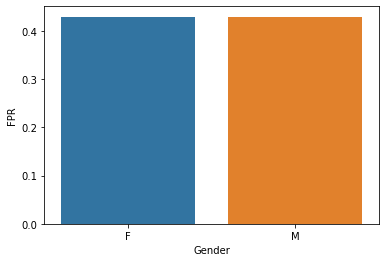

In [91]:
ax = sns.barplot(x=GENDER, y="FPR", data=plot_df)

Copy to clipboard for easy pasting into results sheet

In [102]:
plot_df.to_clipboard(False)

### Age Bias

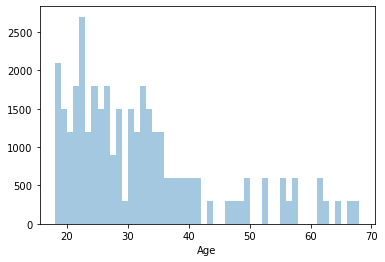

In [92]:
ax = sns.distplot(res[AGE], kde=False, bins=50)

In [93]:
AGE_BUCKET = AGE + "_bucket"
bucket_boundaries = [0, 20, 40, 100] # refer pandas.cut() for syntax on binning

In [94]:
res[AGE_BUCKET] = pd.cut(res[AGE], bins=bucket_boundaries, labels=["young", "middle-age", "old"])
res[[AGE, AGE_BUCKET]].sample(n=5)

,Age,Age_bucket
18113,36,middle-age
3398,24,middle-age
7524,25,middle-age
28831,46,old
25202,31,middle-age


middle-age    24900
old            6300
young          4800
Name: Age_bucket, dtype: int64

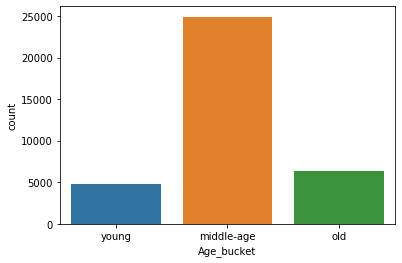

In [95]:
ax = sns.countplot(res[AGE_BUCKET])
res[AGE_BUCKET].value_counts()

In [96]:
age_metrics_df = res.groupby(AGE_BUCKET).apply(metrics_from_df).to_frame("fairness_metrics_per_class")
age_metrics_df

,fairness_metrics_per_class
Age_bucket,
young,"{'TPR': [0.5622909698996655, 0.466777408637873..."
middle-age,"{'TPR': [0.5696166042087056, 0.467706821480406..."
old,"{'TPR': [0.5836533187054306, 0.469480030143180..."


Plot Metrics

In [97]:
plot_df = plot_for_metric_class(age_metrics_df)
plot_df

,Age_bucket,FPR
0,young,0.437709
1,middle-age,0.430383
2,old,0.416347


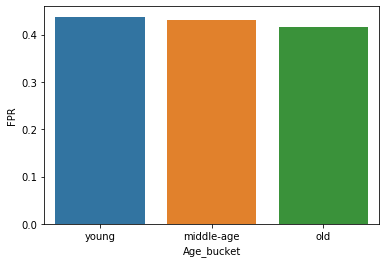

In [98]:
ax = sns.barplot(x=AGE_BUCKET, y="FPR", data=plot_df)

Copy to clipboard for easy pasting into results sheet

In [102]:
plot_df.to_clipboard(False)

## Rough

### Featurize using Feature Columns

Create feature columns like one-hot, embeddings, bucketing from raw features created earlier

In [ ]:
EXAMPLE_BATCH = next(iter(input_fn_train(3)))[0]

In [ ]:
EXAMPLE_BATCH

In [ ]:
def test_feature_column(feature_column):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column)
    return feature_layer(EXAMPLE_BATCH).numpy()

In [ ]:
age_fc = tf.feature_column.numeric_column(AGE, normalizer_fn=lambda x: (x - MEAN_AGE) / STD_AGE)

In [ ]:
zip_fcs = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            f"{ZIP_CODE}{i}", vocabulary_list=list(string.digits), 
            num_oov_buckets=1)
    )
    for i in range(FIRST_K_ZIP_DIGITS)
]

In [ ]:
EXAMPLE_BATCH[AGE], test_feature_column(age_fc)

In [ ]:
{k: v for k, v in EXAMPLE_BATCH.items() if k.startswith(ZIP_CODE)}, test_feature_column(zip_fcs)

In [ ]:
tf.keras.layers.concatenate(age_fc, zip_fcs[0])

### Fairness Indicators using TFMA

In [ ]:
import os
import tempfile
import apache_beam as beam
import numpy as np
import pandas as pd
from datetime import datetime

import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_model_analysis as tfma
import tensorflow_data_validation as tfdv
from tensorflow_model_analysis.addons.fairness.post_export_metrics import fairness_indicators
from tensorflow_model_analysis.addons.fairness.view import widget_view
from fairness_indicators.examples import util

from witwidget.notebook.visualization import WitConfigBuilder
from witwidget.notebook.visualization import WitWidget


In [ ]:
logdir

In [ ]:
y_train[:100, :].shape

In [ ]:
from collections import OrderedDict

In [ ]:
def dl():
    for i in range(100):
        yield OrderedDict({
            FAV: embed_features[FAV]["train"][i, :],
            UNFAV: embed_features[UNFAV]["train"][i, :],
            "non_embed_inputs": X_train[i, :],
            RATING: y_train[i, :]
        })

In [ ]:
dataset = tf.data.Dataset.from_generator(dl, 
            (tf.float32, tf.float32, tf.float32, tf.float32),
            (tf.TensorShape([40]), tf.TensorShape([34]), tf.TensorShape([308]), tf.TensorShape([2])))

In [ ]:
NON_EMBED_INPUTS = "non_embed_inputs"

In [ ]:
dataset = tf.data.Dataset.from_generator(dl, 
            {FAV: tf.float32, UNFAV: tf.float32, NON_EMBED_INPUTS: tf.float32, RATING: tf.float32},
            {FAV: tf.TensorShape([40]), UNFAV: tf.TensorShape([34]), NON_EMBED_INPUTS: tf.TensorShape([308]), RATING: tf.TensorShape([2])})

In [ ]:
fields_to_save = [FAV, UNFAV, NON_EMBED_INPUTS]

In [ ]:
def serialize_example(*example:List[tf.Tensor]):
    """
    Creates a tf.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.Example-compatible data type.
    fields = {field: dtype_feature_map[example[i].dtype](example[i]) for i, field in enumerate(fields_to_save)}

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=fields))
    return example_proto.SerializeToString()

def tf_serialize_example(example:Dict):
    tf_string = tf.py_function(
        serialize_example,
        [example[field] for field in fields_to_save],  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar

In [ ]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    if len(value.shape) > 0:
        return tf.train.Feature(float_list=tf.train.FloatList(value=value))
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    if len(value.shape) > 0:
        return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
dtype_feature_map = {
    tf.dtypes.string: _bytes_feature,
    tf.dtypes.float16: _float_feature,
    tf.dtypes.float32: _float_feature,
    tf.dtypes.float64: _float_feature,
    tf.dtypes.int8: _int64_feature,
    tf.dtypes.int16: _int64_feature,
    tf.dtypes.int32: _int64_feature,
    tf.dtypes.int64: _int64_feature
}

In [ ]:
analysis_data_folder = Path("./analysis_data_with_temporal_as_ints")
analysis_train_data_folder = analysis_data_folder/"train.tfrecords"
analysis_val_data_folder = analysis_data_folder/"val.tfrecords"

analysis_data_folder.mkdir(exist_ok=True, parents=True)

In [ ]:
from shutil import rmtree

In [ ]:
def save_dataset_part(dataset:tf.data, part:int, save_in_folder:Union[Path, str], overwrite=False):
    """
    Save a sharded dataset to a folder
    """
    print(f"Working on part-{part} of the file")
    save_in_folder:Path = Path(save_in_folder) # change to Path object if not already
    overwrite and rmtree(save_in_folder, ignore_errors=True)
    save_in_folder.mkdir(parents=True, exist_ok=True)
    writer = tf.data.experimental.TFRecordWriter(f"{save_in_folder}/part-{part}")
    writer.write(dataset)
    
save_dataset_part_parallel_fn = partial(save_dataset_part, save_in_folder=analysis_data_folder)

In [ ]:
def prepare_dataset_for_save(dataset):
    return dataset.\
        unbatch().\
        map(tf_serialize_example, tf.data.experimental.AUTOTUNE)

In [ ]:
d1 = prepare_dataset_for_save(dataset.batch(1))

In [ ]:
save_dataset_part(d1, 0, analysis_train_data_folder, overwrite=True)

In [ ]:
! ls {logdir}

In [ ]:
#@title Fairness Indicators Computation Options
tfma_eval_result_path = f'{logdir}/tfma_eval_result'

#@markdown Modify the slice_selection for experiments on other identities.
slice_selection = 'gender' #@param ["sexual_orientation", "gender", "religion", "race", "disability"]
#@markdown Confidence Intervals can help you make better decisions regarding your data, but as it requires computing multiple resamples, is slower particularly in the colab environment that cannot take advantage of parallelization.
compute_confidence_intervals = False #@param {type:"boolean"}

# # Define slices that you want the evaluation to run on.
slice_spec = [
    tfma.slicer.SingleSliceSpec(), # Overall slice
    tfma.slicer.SingleSliceSpec(columns=[slice_selection]),
]

# # Add the fairness metrics.
add_metrics_callbacks = [
  tfma.post_export_metrics.fairness_indicators(
      thresholds=[0.1, 0.3, 0.5, 0.7, 0.9],
      labels_key=RATING
      )
]

eval_shared_model = tfma.default_eval_shared_model(
    eval_saved_model_path=(logdir/"keras_saved_model").as_posix(),
    add_metrics_callbacks=add_metrics_callbacks)


In [ ]:
from google.protobuf import text_format

In [ ]:
eval_config = text_format.Parse("""
  # https://www.tensorflow.org/tfx/model_analysis/setup#model_specs
  model_specs {
    # This assumes a serving model with a "serving_default" signature.
    label_key: "%(label_key)s"
  }
  metrics_specs {
    metrics { class_name: "ExampleCount" }
    metrics { class_name: "WeightedExampleCount" }
    metrics { class_name: "SparseCategoricalCrossentropy" }
    metrics { class_name: "SparseCategoricalAccuracy" }
    metrics { class_name: "Precision" config: '"top_k": 1' }
    metrics { class_name: "Precision" config: '"top_k": 3' }
    metrics { class_name: "Recall" config: '"top_k": 1' }
    metrics { class_name: "Recall" config: '"top_k": 3' }
    metrics { class_name: "AUC" }
  }
  # https://www.tensorflow.org/tfx/model_analysis/setup#slicing_specs
  slicing_specs {
    feature_keys: ["Age"]
  }
""" % {"label_key": RATING}, tfma.EvalConfig())

eval_shared_model = tfma.default_eval_shared_model(
    eval_saved_model_path=(logdir/"keras_saved_model").as_posix(), 
    eval_config=eval_config, add_metrics_callbacks=add_metrics_callbacks)

In [ ]:
eval_result = tfma.run_model_analysis(eval_shared_model=eval_shared_model,
                                          eval_config=eval_config,
                                          data_location=(analysis_train_data_folder/"*").as_posix(),
                                          file_format='tfrecords',
#                                           slice_spec=slice_list,
#                                           output_path='sample_data',
#                                           extractors=None, 
                                          desired_batch_size=1024,
                                          random_seed_for_testing=RANDOM_SEED)

In [ ]:
slices = [tfma.slicer.SingleSliceSpec(columns=[AGE])]
tfma.view.render_slicing_metrics(eval_result, slicing_spec=slices[0])

In [ ]:
validate_tf_file = "analysis_data_with_temporal_as_ints/train.tfrecords/part-0"

In [ ]:
# Run the fairness evaluation.
with beam.Pipeline() as pipeline:
    _ = (
      pipeline
      | 'ReadData' >> beam.io.ReadFromTFRecord(validate_tf_file)
      | 'ExtractEvaluateAndWriteResults' >>
       tfma.ExtractEvaluateAndWriteResults(
                 eval_shared_model=eval_shared_model,
                 slice_spec=slice_spec,
                 compute_confidence_intervals=compute_confidence_intervals,
                 output_path=tfma_eval_result_path)
    )

#     eval_result = tfma.load_eval_result(output_path=tfma_eval_result_path)

In [ ]:
logdir

In [ ]:
def create_target_for_model(d:Dict, target_col:str=RATING) -> Tuple[Dict, np.array]:
    target = d.pop(target_col)
    return d, target

In [ ]:
for d in dataset.batch(1).take(2):
    pprint(d)

In [ ]:
for d in dataset.map(create_dataset_pd).take(2):
    pprint(d)

In [ ]:
for d in dl():
    for k in d:
        print(k, d[k].shape)
    break

In [ ]:
tf.data.Dataset.from_generator()

In [ ]:
num_samples = 100

pd.DataFrame(
    {
        FAV: embed_features[FAV]["train"][:num_samples, :],
        UNFAV: embed_features[UNFAV]["train"][:num_samples, :],
        "non_embed_inputs": X_train[:num_samples, :],
        RATING: y_train[:num_samples, :]
    },
    index=range(num_samples)
)

In [ ]:
beam.io.ReadF

In [ ]:
eval_shared_model??

In [ ]:
tfma.ExtractEvaluateAndWriteResults??

### Fairness Indicators using IBM's AIF360 Library

```
@misc{aif360-oct-2018,
    title = "{AI Fairness} 360:  An Extensible Toolkit for Detecting, Understanding, and Mitigating Unwanted Algorithmic Bias",
    author = {Rachel K. E. Bellamy and Kuntal Dey and Michael Hind and
	Samuel C. Hoffman and Stephanie Houde and Kalapriya Kannan and
	Pranay Lohia and Jacquelyn Martino and Sameep Mehta and
	Aleksandra Mojsilovic and Seema Nagar and Karthikeyan Natesan Ramamurthy and
	John Richards and Diptikalyan Saha and Prasanna Sattigeri and
	Moninder Singh and Kush R. Varshney and Yunfeng Zhang},
    month = oct,
    year = {2018},
    url = {https://arxiv.org/abs/1810.01943}
}
```

In [ ]:
! ./setup.sh # uncomment if you wish to install any new packages

In [ ]:
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

In [ ]:
from aif360.metrics import DatasetMetric

In [ ]:
import aif360.sklearn.metrics as fm

In [ ]:
fm